# Segmentace ledvin prasete domácího z CT snímků

Cílem je automaticky segmentovat zvlášť levou a zvlášť pravou ledvinu.

Odevzdání musí splňovat následující podmínky:
    
 * Kód musí být uložen a dostupný na metacentru ([přihláška](https://metavo.metacentrum.cz/osobniv3/wayf/proxy.jsp?locale=cs&target=https%3A%2F%2Fsignup.e-infra.cz%2Ffed%2Fregistrar%2F%3Fvo%3Dmeta%26locale%3Dcs)) a přístupný pro čtení pro "others"
 * Dejte nám vědět, kde je Váš kód uložen prostřednictvím [formuláře](https://forms.gle/E7TmtVPzqoH9g9US8)
 * Musí obsahovat soubor `run_zdo.py`
 * Musí být spustitelný:
     
         run_zdo.py vstupni_adresar vystupni_adresar


 * všechny soubory s příponou nii.gz jakkoliv vnořené ve vstupním adresáři jsou zpracovány
 * výsledky jsou ve výstupním adresáři, struktura kopíruje vstupní adresár
 * levá ledvina má příponu `.left_kidney.nii.gz` pravá má příponu `.right_kidney.nii.gz`
 * ve výstupním adresáři je rovněž adresář `visualization` ve kterém jsou dokumentovány jednotlivé kroky algoritmu (prahování, filtrace, ...)
 * Doba zpracování jednoho CT nesmí přesáhnout 30s
 
 * Kód musí být uložen na GitHub repozitář (soukromém) a vyučující do něj musí být přidán jako spolupracovník
 * Po uplynutí odevzdání bude kód zveřejněn pod MIT licencí
 
# Data

Data z CT jsou volumetrická, uložená v 3D poli, v souboru `.nii.gz`, kde každý voxel může nabývat kladných i záporných hodnot. Na rozdíl od normálních fotografií jsou hodnoty CT snímků normalizovány a intenzita (rovněž označovaná jako denzita) je měřena v Hounsfieldových jednotkách [HU]. Typické hodnoty jsou:
 * Vzduch: -1000 HU
 * Svaly: 45 HU
 * Kosti: 200 až 1000 HU

# Trocha anatomie


![97a3af7b91f1a2ff656d763d676c82213b6249ee.png](97a3af7b91f1a2ff656d763d676c82213b6249ee.png)
Computed tomography cuts with intravenous contrast in animal 1. (a) transversal section; (b) sagittal section; (c) coronal section; 1: right kidney; 2: left kidney; 3: abdominal aorta; 4: caudal vena cava; 5: right renal vein; 6: left renal vein; 7: liver; 8: small intestine; 9: large intestine; 10: stomach ([převzato z Image-guided study of swine anatomy...](https://doi.org/10.1590/ACB351208))


# Odkazy a inspirace 

 * Pusťte si jupyter notebook na metacentru pomocí služby [on demand](https://ondemand.grid.cesnet.cz/)
 * Zkuste neuronku: [Segment Anything Model](https://colab.research.google.com/drive/1PDyN7siozm25lQYpiDgUocSGMca-fx1W?usp=sharing)
 * [Afinní transformace v io3d](https://github.com/mjirik/io3d/blob/master/examples/affine_transform.ipynb)
 * [Metriky pro 3D segmentaci orgánů](https://github.com/mjirik/imma/blob/master/examples/sliver_evaluation.ipynb)
 * [Anatomie prasete](https://www.scielo.br/j/acb/a/4fCHJrFrtsmh4x46W83VTzr/?lang=en)
 * [Tento notebook na GitHubu](https://github.com/mjirik/zdo2025)
 
 
# Kontakt
 mjirik@kky.zcu.cz

In [65]:
# nastavení přístupu pro others ve dvou krocích (první pro všechny soubory, druhý ještě přidává možnost procházení adresářům)
# chmod -R o+r /cesta/k/adresari
# find /cesta/k/adresari -type d -exec chmod o+x {} \;

In [66]:

%load_ext autoreload
%autoreload 2


# !pip install git+https://github.com/mjirik/io3d --upgrade --force-reinstall 
# !pip install git+https://github.com/mjirik/imma --upgrade --force-reinstall 
    
!pip install git+https://github.com/mjirik/io3d 
!pip install git+https://github.com/mjirik/imma 

!pip install tqdm scikit-image loguru pydicom nibabel

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Cloning https://github.com/mjirik/io3d to /var/tmp/pbs.9403333.pbs-m1.metacentrum.cz/pip-req-build-7ge4l0yw
  Running command git clone --filter=blob:none --quiet https://github.com/mjirik/io3d /var/tmp/pbs.9403333.pbs-m1.metacentrum.cz/pip-req-build-7ge4l0yw
  Resolved https://github.com/mjirik/io3d to commit adcec452fdbf683990c8e8fede1835f5b0e0dfaf
  Preparing metadata (setup.py) ... done

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Cloning https://github.com/mjirik/imma to /var/tmp/pbs.9403333.pbs-m1.metacentrum.cz/pip-re

In [67]:
from pathlib import Path
import os
import io3d
import matplotlib.pyplot as plt
import imma
import numpy as np

In [68]:
dataset_path = Path(os.environ.get("DATA_PP", default="/storage/plzen4-ntis/projects/korpusy-public/ZDO/ZDO2025/pilsen_pigs_all/transplantation_nii_transposed_zdo"))
assert dataset_path.exists(), "Data not found"
output_dir=Path(".")

# Process one 3D image

In [69]:
fn = list(dataset_path.glob("**/*.nii.gz"))[1]
fn

PosixPath('/storage/plzen4-ntis/projects/korpusy-public/ZDO/ZDO2025/pilsen_pigs_all/transplantation_nii_transposed_zdo/Tx030D_Ven/Tx030D_Ven.nii.gz')

In [71]:
datap = io3d.read(fn)
# size of voxel
datap.voxelsize_mm

(0.88314843, 0.88314843, 0.8)

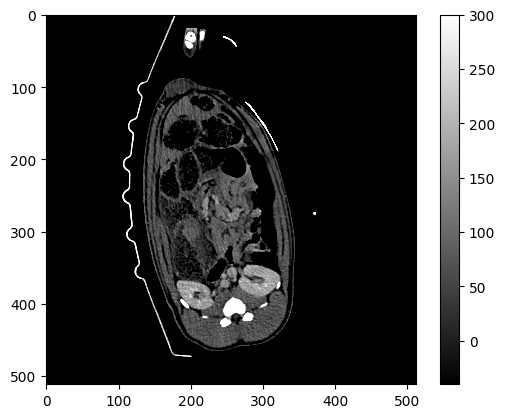

In [72]:
plt.imshow(data3d[:,:,i], cmap="gray", clim=[-40, 300])
plt.colorbar()
plt.show()

In [73]:
datap.data3d.shape

(512, 512, 1065)

## Histogram

Hodnoty kolem -1000 odpovídají vzduchu, zatímco hodnoty kolem nuly odpovídají tkáním.

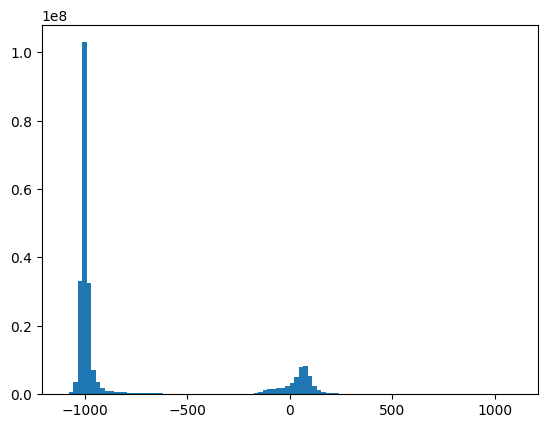

In [74]:
hist_data = plt.hist(datap.data3d.flatten(), bins=100, range=[-1100, 1100])

## Axiální řez

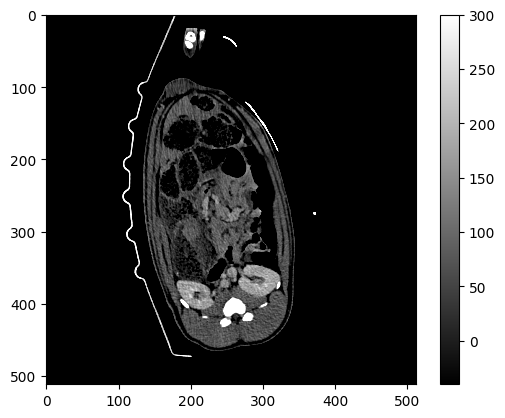

In [75]:
# show i-th slice
i = 450
plt.imshow(datap.data3d[:,:,i], cmap="gray", clim=[-40, 300])
plt.colorbar()
plt.show()

## Předo-zadní řez

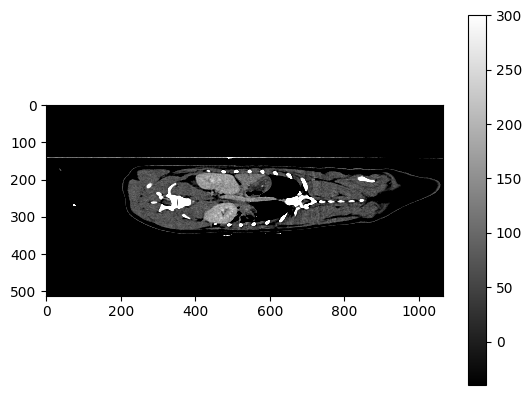

In [76]:
# show i-th slice
i = 380
plt.imshow(datap.data3d[i,:,:], cmap="gray", clim=[-40, 300])
plt.colorbar()
plt.show()

### Max-projection

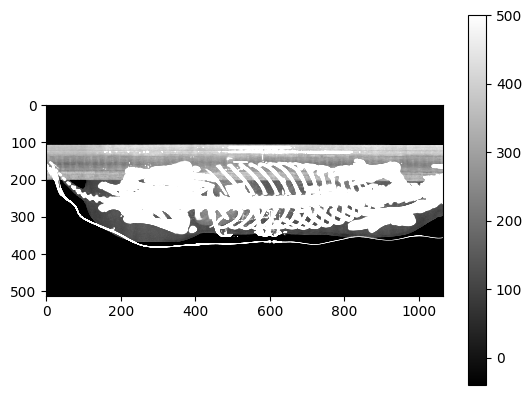

In [77]:
# show i-th slice
i = 380
plt.imshow(np.max(datap.data3d, axis=0), cmap="gray", clim=[-40, 500])
plt.colorbar()
plt.show()

## My segmentation algorithm

In [78]:

seg = datap.data3d > 55


In [79]:
from typing import Union, List

def write_nii(data3d:np.ndarray, voxelsize_mm:Union[List,np.ndarray], file_name:Union[str,Path]):
    affine = np.diag(list(voxelsize_mm) + [1])
    img = nib.Nifti1Image(data3d.astype(np.uint8),affine)
    nib.save(img, left_kidney_file_name)

### Write output

In [80]:
left_kidney_file_name = output_dir / fn.name.replace(".nii.gz", ".left_kidney.nii.gz")

write_nii(seg.astype(np.uint8), datap.voxelsize_mm, left_kidney_file_name)

### Check the segmentation

In [81]:

datap_lk = io3d.read(left_kidney_file_name)

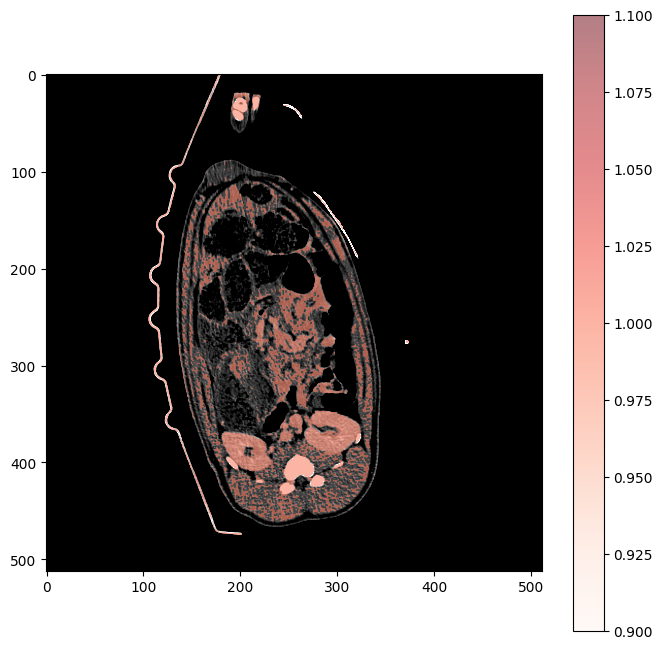

In [82]:

i = 450

# Display the CT slice
plt.figure(figsize=(8, 8))
plt.imshow(datap.data3d[:, :, i], cmap="gray", clim=[-40, 300])
# plt.colorbar()

# Create a masked array where 0 (or your background value) is masked out
mask = datap_lk.data3d[:, :, i]
mask_display = np.ma.masked_where(mask == 0, mask)

# Overlay the kidney mask in red with transparency
plt.imshow(mask_display, cmap="Reds", alpha=0.5)
plt.colorbar()

plt.show()

## Ground Truth Mask

In [83]:
dataset_annotation_path = Path(os.environ.get("DATA_PP", default="/storage/plzen4-ntis/projects/korpusy-public/ZDO/ZDO2025/pilsen_pigs_all/transplantation_nii_transposed_zdo_annotation"))
assert dataset_annotation_path.exists(), "Data not found"

fna = list(dataset_annotation_path.glob("**/*.nii.gz"))[0]
datap_ann = io3d.read(fna)
# size of voxel
print(datap_ann.voxelsize_mm)
print(datap_ann.data3d.shape)
gt_segmentation = datap_ann.data3d

(0.88314843, 0.88314843, 0.8)
(512, 512, 1065)


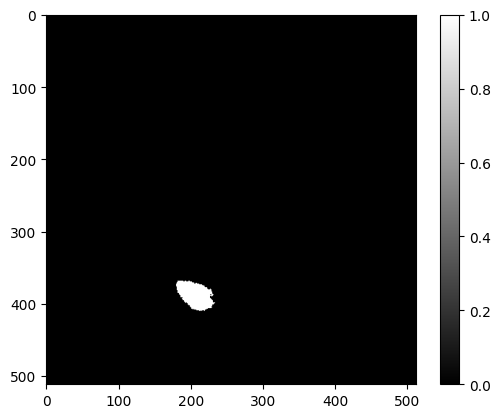

In [84]:
i = 450
plt.imshow(datap_ann.data3d[:,:,i], cmap="gray")
plt.colorbar()
plt.show()

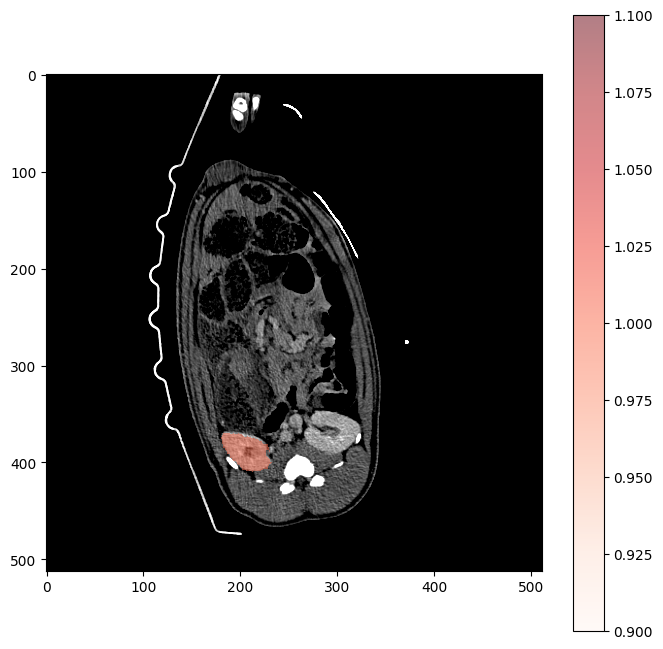

In [85]:

i = 450

# Display the CT slice
plt.figure(figsize=(8, 8))
plt.imshow(datap.data3d[:, :, i], cmap="gray", clim=[-40, 300])
# plt.colorbar()

# Create a masked array where 0 (or your background value) is masked out
mask = datap_ann.data3d[:, :, i]
mask_display = np.ma.masked_where(mask == 0, mask)

# Overlay the kidney mask in red with transparency
plt.imshow(mask_display, cmap="Reds", alpha=0.5)
plt.colorbar()

plt.show()

# Compare GT with my segmentation

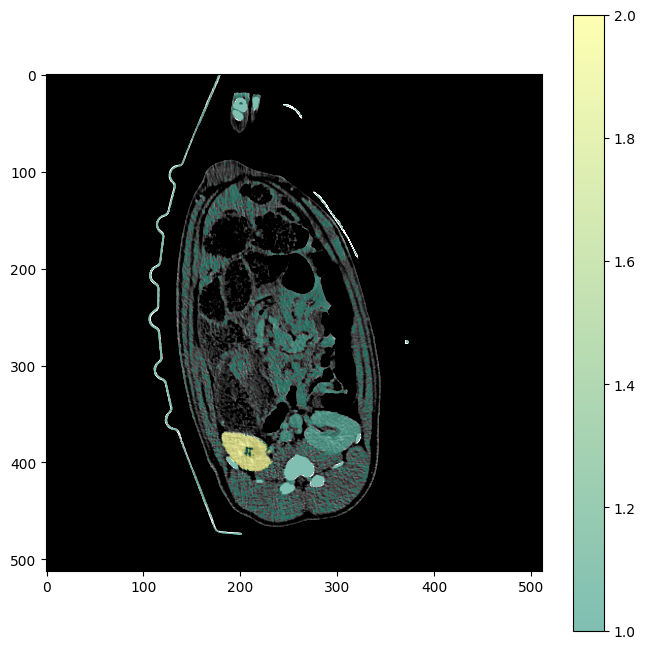

In [86]:
i = 450

# Display the CT slice
plt.figure(figsize=(8, 8))
plt.imshow(datap.data3d[:, :, i], cmap="gray", clim=[-40, 300])
# plt.colorbar()

# Create a masked array where 0 (or your background value) is masked out
mask = datap_ann.data3d[:, :, i] + seg[:,:,i]
mask_display = np.ma.masked_where(mask == 0, mask)

# Overlay the kidney mask in red with transparency
plt.imshow(mask_display, cmap="summer", alpha=0.5)
plt.colorbar()

plt.show()

# Simple IoU evaluation

In [87]:
import numpy as np

def compute_iou_volume(ground_truth, segmentation):
    # Convert the segmentation and ground truth to boolean arrays
    segmentation = segmentation.astype(bool)
    ground_truth = ground_truth.astype(bool)
    
    # Calculate intersection and union over the entire volume
    intersection = np.logical_and(segmentation, ground_truth).sum()
    union = np.logical_or(segmentation, ground_truth).sum()
    
    # Avoid division by zero
    if union == 0:
        return 0.0
    iou = intersection / union
    return iou

In [88]:
gt_segmentation = datap_ann.data3d

compute_iou_volume(gt_segmentation, seg)

0.005968699412492205

# Advanced Evaluation

Described in paper

Heimann, T., van Ginneken, B., Styner, M. a, Arzhaeva, Y., Aurich, V., Bauer, C., … Wolf, I. (2009). Comparison and evaluation of methods for liver segmentation from CT datasets. IEEE Transactions on Medical Imaging, 28(8), 1251–1265. https://doi.org/10.1109/TMI.2009.2013851

## General metrics independent on volume type
compare_volumes(ground_true, segmentation, voxelsize_mm)

 * `volume1_mm3`: Ground True volume in [mm^3] 
 * `volume2_mm3`: Volume of segmentation in [mm^3]
 * `err1_mm3`: undersegmentation
 * `err2_mm3`: oversegmentation
 * `err1_percent`: undersegmentation in [%]
 * `err2_percent`: oversegmentation in [%]
 * `vd`: Volume difference, negative is means smaller volume of segmentation than ground true
 * `voe`: Volumetric Error
 * `avgd`: Average surface difference
 * `jaccard`: Jaccard index = Intersection over Union

In [ ]:
import imma.volumetry_evaluation

In [ ]:
# evaluation = imma.volumetry_evaluation.compare_volumes(gt_segmentation, seg, voxelsize_mm = datap.voxelsize_mm)
# evaluation